In [1]:
import pathlib
import os
from datetime import datetime as DT
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.ticker as mtick
from matplotlib import rcParams
from matplotlib import colors
from cmocean import cm 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.geoaxes import GeoAxes
from IPython.core.display import HTML, display

In [2]:
display(HTML("<style>.container{width: 90% !important}</style>"))

In [3]:
# Global graphic settings
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['ytick.minor.visible']=True

In [4]:
% matplotlib inline

In [14]:
def set_ticks(ax, lat_ticks, lon_ticks, transform):
    ax.set_xticks(lon_ticks, minor=True, crs=transform)
    ax.set_yticks(lat_ticks, crs=transform)
    ax.xaxis.set_minor_locator(mtick.FixedLocator(range(-180, 181, 10)))
    ax.yaxis.set_minor_locator(mtick.FixedLocator(range(-90, 90, 10)))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)


def set_map1(ax, transform):    
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, facecolor='gray')
    ax.add_feature(cf.OCEAN, zorder=0, facecolor='k')
    lon_ticks = range(0, 361, 60)
    lat_ticks = range(-60, 61, 60) 
    isot=dict(north=df_north, south=df_south)
    plot_isotherm(ax, isot['north'], transform=transform)
    plot_isotherm(ax, isot['south'], transform=transform)
    set_ticks(ax, lat_ticks, lon_ticks, transform=transform)
    return None
    
def set_map2(ax, transform, set_xticks):    
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, facecolor='gray')
    ax.add_feature(cf.OCEAN, zorder=0, facecolor='k')
    if set_xticks:
        lon_ticks = range(0, 361, 60)
    else:
        lon_ticks = None
    lat_ticks = range(-60, 61, 60) 
    isot=dict(north=df_north, south=df_south)
    plot_isotherm(ax, isot['north'], transform=transform)
    plot_isotherm(ax, isot['south'], transform=transform)
    set_ticks(ax, lat_ticks, lon_ticks, transform=transform)
    return None

    
def map_ax(ax, data_array, **kwargs):
    vmin = kwargs.pop('vmin', 0.01)
    vmax = kwargs.pop('vmax', 20)
    cmap = kwargs.pop('cmap', 'viridis')
    cb_payload = kwargs.pop('cb_payload', {'ticks': mtick.LogLocator(subs=range(10)),
                                           'orientation':'vertical',
                                           'fraction': 0.03,
                                           'pad': -0.005,
                                           'label': '$mg\ m^{-3}$',
                                           'extend':'neither',
                                           'aspect': 20,
                                           'shrink': 0.7
                                          }
                           )
    transform = kwargs.pop('transform', ccrs.PlateCarree())
    set_map1(ax, transform)
    artist = data_array.plot.pcolormesh(x='lon', y='lat', norm=colors.LogNorm(),
                                       ax=ax, transform=transform, cmap=cmap,
                                       vmin=vmin, vmax=vmax,
                                       cbar_kwargs=cb_payload
                                       )
    ax.set_xlabel('')
    ax.set_ylabel('')
    return artist


def map_ax2(ax, data_array, **kwargs):
    vmin = kwargs.pop('vmin', data_array.min())
    vmax = kwargs.pop('vmax', data_array.max())
    step = kwargs.pop('step', 10)
    set_xticks = kwargs.pop('set_xticks', False)
    cmap = kwargs.pop('cmap', cm.balance)
    add_cbar = kwargs.pop('add_cbar', True)
    set_xticks = kwargs.pop('set_xticks', True)
    cb_payload = kwargs.pop('cb_payload', {'orientation': 'vertical',
                                           'fraction': 0.03, 'pad': -0.005,
                                           'label': r'$mg\ m^{-3}$',
                                           'extend':'neither',
                                           'aspect': 20,
                                           'shrink': 0.7,
                                          }                     )
    transform = kwargs.pop('transform', ccrs.PlateCarree())
    set_map2(ax, transform, set_xticks)
    artist_payload = dict(x='lon', y='lat', ax=ax, transform=transform,
                         cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=add_cbar)
    if add_cbar:
        bar_ticks = mtick.FixedLocator(np.arange(vmin, vmax+step, step))
        cb_payload.update({'ticks': bar_ticks,})
        artist_payload.update(dict(cbar_kwargs=cb_payload))
    
    artist = data_array.plot.pcolormesh(**artist_payload)
    ax.set_xlabel('')
    ax.set_ylabel('')
    return artist


def format_cbar_ticks(quadmesh, ax, ticks=None,
                      tick_labels=['Chl- SST-', 'Chl- SST+', 'Chl+ SST-', 'Chl+ SST+'],
                     **kwargs):
    cax = pl.colorbar(mappable=quadmesh, ax=ax, fraction=0.02, pad=0.01)
    if ticks is None:
        cax.set_ticks(np.arange(len(tick_labels)))
    else:
        cax.set_ticks(ticks)
    if tick_labels:
        cax.set_ticklabels(tick_labels)
    return cax


def plot_isotherm(ax, df, transform):
    ax.plot(df.lon, df.lat, zorder=1, lw=3, color='k', transform=transform)
    return None

In [15]:
xr_anom = xr.open_dataset('./xr_anom_2018.nc')
df_south = pd.read_csv('../sst_iso_south.txt', delim_whitespace=True,
                       names=['lon', 'lat'])
df_north = pd.read_csv('../sst_iso_north.txt', delim_whitespace=True,
                      names=['lon', 'lat'])
ds = xr.open_dataset('./xr_sst_chl_2019-02-07 10:07:40.833574.nc')

In [16]:
lat1 = ds.lat
lat2 = xr_anom.lat
lon1, lon2 = ds.lon, xr_anom.lon

In [17]:
xr.testing.assert_equal(lat1, lat2)

In [18]:
xr.testing.assert_equal(lon1, lon2)

In [11]:
chl_payload = {'ticks': mtick.LogLocator(subs=range(10)),
                'orientation': 'vertical',
                'fraction': 0.02,
                'pad': 0.01,
                'label': '$chl.\ a\ (mg\ m^{-3})$',
                'extend':'neither',
                'aspect': 20,
                'shrink': 0.7
                }

chl_anom_payload = {'orientation': 'vertical',
               'fraction': 0.03, 'pad': -0.005,
               'label': r'$mg\ m^{-3}$',
               'extend':'neither',
               'aspect': 20,
               'shrink': 0.7,
                   }   
sst_anom_payload = {'ticks': mtick.LogLocator(subs=range(10)),
               'orientation': 'vertical',
               'fraction': 0.02, 'pad': 0.01,
               'label': r'SST Anomaly ($^\circ C$)',
               'extend':'neither',
               'aspect': 20,
               'shrink': 0.7}   

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


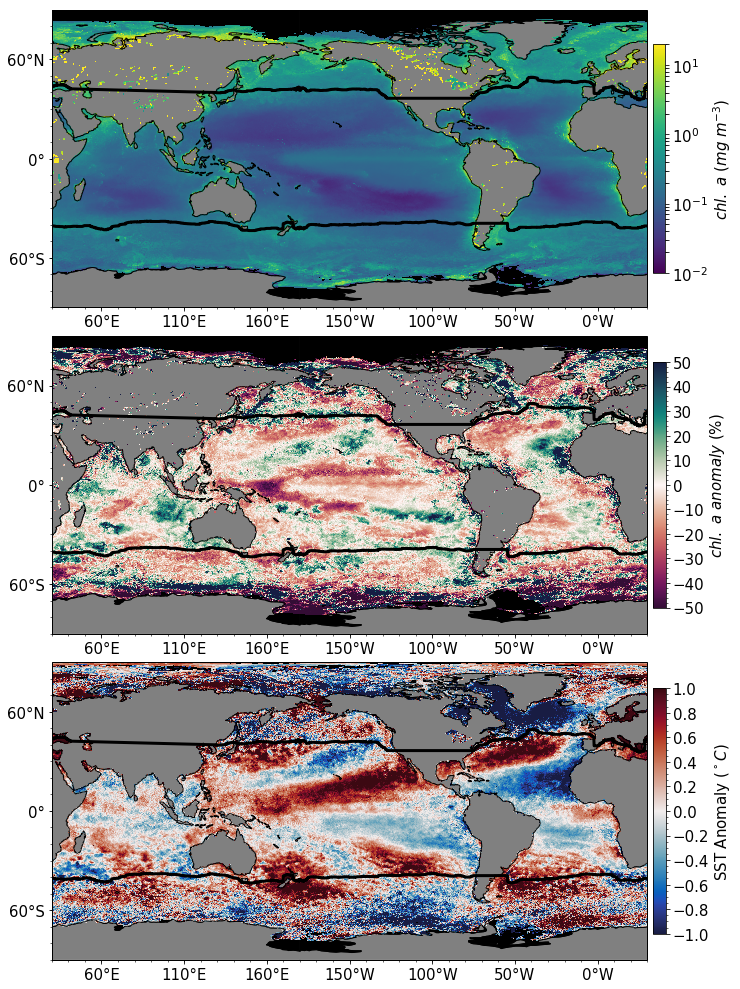

In [25]:
# 3-panel version with chl, chl anom, sst
central_long = -150
tran = ccrs.PlateCarree(central_longitude=central_long)
lat = xr_anom.lat
lon = xr_anom.lon
chl_ = ds.year_avg_aqua_chl
sst_ = ds.year_avg_aqua_sst
chl_anom = xr_anom.time_avg_aqua_chl_anom
sst_anom = xr_anom.time_avg_sst_anom

f_3panel, axs = pl.subplots(nrows=3, figsize=(11, 18),
                         subplot_kw={'projection': tran})

f_3panel.subplots_adjust(hspace=0)
qm_chl = map_ax(axs[0], chl_, add_cbar=False, cb_payload=chl_payload)
qm_chl_anom = map_ax2(axs[1], chl_anom, vmin=-50, vmax=50, cmap=cm.curl_r,
                  add_cbar=False)
cax = format_cbar_ticks(qm_chl_anom, ax=axs[1], ticks=range(-50, 51, 10), tick_labels=None)
cax.set_label(r'$chl.\ a\ anomaly\ (\%)$')
"""qm_sst = map_ax2(axs[2], sst_, vmin=1, vmax=40, cb_payload=sst_payload,
                  add_cbar=False, cmap=cm.thermal)
cax = format_cbar_ticks(qm_sst, ax=axs[2], ticks=np.arange(0, 40, 5), tick_labels=None)
cax.set_label(r'$SST\ (^\circ C)$')"""
qm_sst_anom = map_ax2(axs[2], sst_anom, vmin=-1, vmax=1, step=0.2,
                   cb_payload=sst_anom_payload, add_cbar=False)
cax = format_cbar_ticks(qm_sst_anom, ax=axs[2], ticks=np.arange(-1, 1.2, 0.2),
                        tick_labels=None)
cax.set_label(r'SST Anomaly ($^\circ C$)')

In [26]:
f_3panel.savefig('../FigJar/maps_3panel_w_sst_anomaly%s.png' % DT.now(),
                 dpi=300, format='png')